In [2]:
import nighres
from nighres.intensity import lcat_denoising
import nilearn
from nilearn import plotting
import nibabel as nib
import numpy as np
import os
import shutil
%matplotlib inline


In [2]:
# try sub-01 run-1

In [3]:
run_dir = os.getcwd() + '/data/deriv/fmriprep/sub-01/ses-me/func'
fns = ['sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz',
       'sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz',
       'sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz']

*just* to be sure, copy these files to a new directory to prevent fuck-ups (by me)

In [10]:
lcat_run_dir = os.path.join(os.getcwd(), 'lcat_denoising')
if not os.path.exists(lcat_run_dir):
    os.mkdir(lcat_run_dir)
    
# for fn in fns:
#     shutil.copy2(os.path.join(run_dir, fn), lcat_run_dir)

In [ ]:
image_list = [os.path.join(lcat_run_dir, fn) for fn in fns]
image_list

['/home/stevenm/MultiEchoEPISeq/lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz',
 '/home/stevenm/MultiEchoEPISeq/lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz',
 '/home/stevenm/MultiEchoEPISeq/lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz']

In [7]:
?lcat_denoising

In [ ]:
result = lcat_denoising(image_list, save_data=True, output_dir=lcat_run_dir,
                        )


LCaT denoising

Outputs will be saved to /home/stevenm/MultiEchoEPISeq/lcat_denoising/


In [13]:
# './data/raw/bids/sub-01/ses-me/func/'
## also denoise the *raw* timeseries
run_dir = os.getcwd() + '/data/raw/bids/sub-01/ses-me/func'
fns = ['sub-01_ses-me_task-stop_run-1_echo-1_bold.nii',
       'sub-01_ses-me_task-stop_run-1_echo-2_bold.nii',
       'sub-01_ses-me_task-stop_run-1_echo-3_bold.nii']

In [14]:
lcat_run_dir = os.path.join(os.getcwd(), 'lcat_denoising')
if not os.path.exists(lcat_run_dir):
    os.mkdir(lcat_run_dir)
    
for fn in fns:
    shutil.copy2(os.path.join(run_dir, fn), lcat_run_dir)

In [15]:
image_list = [os.path.join(lcat_run_dir, fn) for fn in fns]
image_list

['/home/stevenm/MultiEchoEPISeq/lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-1_bold.nii',
 '/home/stevenm/MultiEchoEPISeq/lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-2_bold.nii',
 '/home/stevenm/MultiEchoEPISeq/lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-3_bold.nii']

In [ ]:
result = lcat_denoising(image_list, save_data=True, output_dir=lcat_run_dir)


LCaT denoising

Outputs will be saved to /home/stevenm/MultiEchoEPISeq/lcat_denoising/


/home/stevenm/miniconda3/lib/python3.7/site-packages/nighres/intensity/lcat_denoising.py:135: DeprecationWarning: get_affine method is deprecated.
Please use the ``img.affine`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  affine = img.get_affine()
/home/stevenm/miniconda3/lib/python3.7/site-packages/nighres/intensity/lcat_denoising.py:136: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  header = img.get_header()


## It ran, let's see what it looks like

In [1]:
### combine functions
def combine_tedana(tes, data, combmode='t2s', mask=None):
    """ Function based on tedana main workflow """
    from tedana import utils, model
    from scipy import stats
    import numpy as np
    import os
    
    # ensure tes are in appropriate format
    tes = [float(te) for te in tes]
    n_echos = len(tes)

    # coerce data to samples x echos x time array
    if isinstance(data, str):
        data = [data]

    catd, ref_img = utils.load_data(data, n_echos=n_echos)
    n_samp, n_echos, n_vols = catd.shape
    
    mask, masksum = utils.make_adaptive_mask(catd, mask=mask,
                                             minimum=False, getsum=True)

    
    # check if the t2s-map is already created first
    base_name = data[0].replace('_echo-1', '_%s').replace('.nii', '').replace('.gz', '')
    if not os.path.exists(base_name %'t2sv' + '.nii.gz'):
        t2s, s0, t2ss, s0s, t2sG, s0G = model.fit_decay(catd, tes, mask, masksum)
        # set a hard cap for the T2* map
        # anything that is 10x higher than the 99.5 %ile will be reset to 99.5 %ile
        cap_t2s = stats.scoreatpercentile(t2s.flatten(), 99.5,
                                          interpolation_method='lower')
        t2s[t2s > cap_t2s * 10] = cap_t2s
        
        # save
        utils.filewrite(t2s, base_name %'t2sv' + '.nii', ref_img, gzip=True)
        utils.filewrite(s0, base_name %'s0v' + '.nii', ref_img, gzip=True)
        utils.filewrite(t2ss, base_name %'t2ss' + '.nii', ref_img, gzip=True)
        utils.filewrite(s0s, base_name %'s0vs' + '.nii', ref_img, gzip=True)
        utils.filewrite(t2sG, base_name %'t2svG' + '.nii', ref_img, gzip=True)
        utils.filewrite(s0G, base_name %'s0vG' + '.nii', ref_img, gzip=True)
        
    else:
        t2sG = utils.load_image(base_name %'t2svG' + '.nii.gz')
        t2s = utils.load_image(base_name %'t2sv' + '.nii.gz')
        
    # optimally combine data
    data_oc = model.make_optcom(catd, tes, mask, t2s=t2sG, combmode=combmode)
    if combmode == 't2s':
        ext = 'optcomb'
    else:
        ext = 'PAID'
    print('Combined, writing results...')
    
    # make sure to set all nan-values/inf to 0
    data_oc[np.isinf(data_oc)] = 0
    data_oc[np.isnan(data_oc)] = 0
    utils.filewrite(data_oc, base_name %ext + '.nii', ref_img, gzip=True)

In [9]:
### combine echos (optcomb)
tes = [9.66, 24.78, 40.08]
imgs = ['./lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz',
        './lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz',
        './lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz']
combine_tedana(tes, imgs, mask='./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_brainmask.nii.gz')

Combined, writing results...


/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


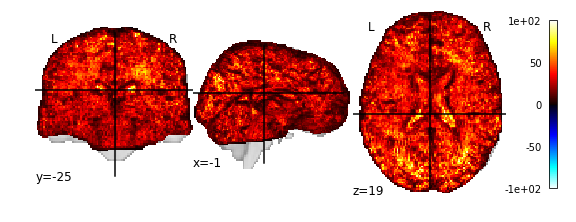

In [16]:
## plot tSNR?
def tsnr_img(hdr):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
        
    dat = hdr.get_data()
    mn = np.mean(dat, 3)
    sd = np.std(dat, 3)
    
    img = nib.Nifti1Image(mn/sd, hdr.affine)
    return img

plotting.plot_stat_map(tsnr_img('./lcat_denoising/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz'), vmax=100)

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


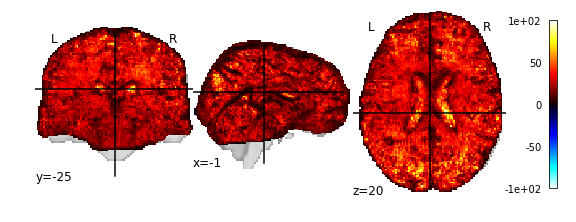

In [17]:
plotting.plot_stat_map(tsnr_img('./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'), vmax=100)

#### Deconvolve both signals, compare difference

In [89]:
# get data
import scipy as sp

def include(mask, threshold_percentile=.3):
#     def normalize(x):
#         x = np.asarray(x)
#         return (x - x.min()) / (np.ptp(x))
    
    if not isinstance(mask, nib.Nifti1Image):
        if isinstance(mask, str):
            mask = nib.load(mask)
    
    dat = mask.get_data()
#     dat_normalized = normalize(dat)
    dat_include = np.array(dat > (threshold_percentile*100), dtype=float)
    
    img = nib.Nifti1Image(dat_include, mask.affine)
    return img

def create_single_timeseries(imgs, mask, mask_threshold=0.3, tr=3., hp=1/128.):
    from nilearn import masking
    masked_data = [masking.apply_mask(x, include(mask, mask_threshold)) for x in imgs]
    masked_data_mean = [x.mean(1) for x in masked_data]  # mean within mask here

    if hp is None:
        return masked_data_mean
    else:
        sample_rate = 1/float(tr)
        highpassed_data = []
        for x in masked_data_mean:
    #        timepoints = np.arange(x.shape[0]*tr, step=tr)

            # High pass:
            hp_cof_sample = hp /  (sample_rate / 2)
            bhp, ahp = sp.signal.butter(3, hp_cof_sample, btype='highpass')
            data_highpass = sp.signal.filtfilt(bhp, ahp, x)  # this also demeans
    #        data_highpass = data_highpass + x.mean()
            data_highpass = sp.stats.zscore(data_highpass)  # get z-score for concatenation
            highpassed_data.append(data_highpass)

        return highpassed_data


# get events
def get_event_data(subject_id, session, run, bids_root='./data/deriv/fmriprep', event_types=('go_trial', 'successful_stop', 'failed_stop')):
    import pandas

    fn = os.path.join(bids_root, 'sub-' + subject_id, 'ses-' + session, 
                      'func', 'sub-{}_ses-{}_task-stop_run-{}_events.tsv'.format(subject_id, session, run))
    df = pandas.read_csv(fn, sep='\t')

    # Since many subjects do not have errors and we want the design matrices to be the same(did I write this??)
    # across subjects, we only look at correct trials
    to_return = df[np.in1d(df.trial_type, event_types)].fillna(0.1)

    return to_return

all_events = get_event_data('01', 'me', 1)
events = [np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'onset'].tolist()]),
          np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'onset'].tolist()]),
          np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'onset'].tolist()])
         ]

durations = {'go_trial': np.array([x for x in all_events.loc[all_events.trial_type=='go_trial', 'duration'].tolist()]),
             'successful_stop': np.array([x for x in all_events.loc[all_events.trial_type=='successful_stop', 'duration'].tolist()]),
             'failed_stop':np.array([x for x in all_events.loc[all_events.trial_type=='failed_stop', 'duration'].tolist()])
            }

# data = create_single_timeseries(['./lcat_denoising/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz'],
#                                mask='masks/final_masks_mni09a_1p6mm/ACC_def-img.nii.gz')

# ### Fir
# fd = fir.FIRDeconvolution(signal=np.hstack(tmp), 
#                           events=events, 
#                           event_names=('go_trial', 'successful_stop', 'failed_stop'), 
#                           durations=durations,
#                           sample_frequency=sample_rate, 
#                           deconvolution_frequency=deconv_frequency, 
#                           deconvolution_interval=[0,interval],)

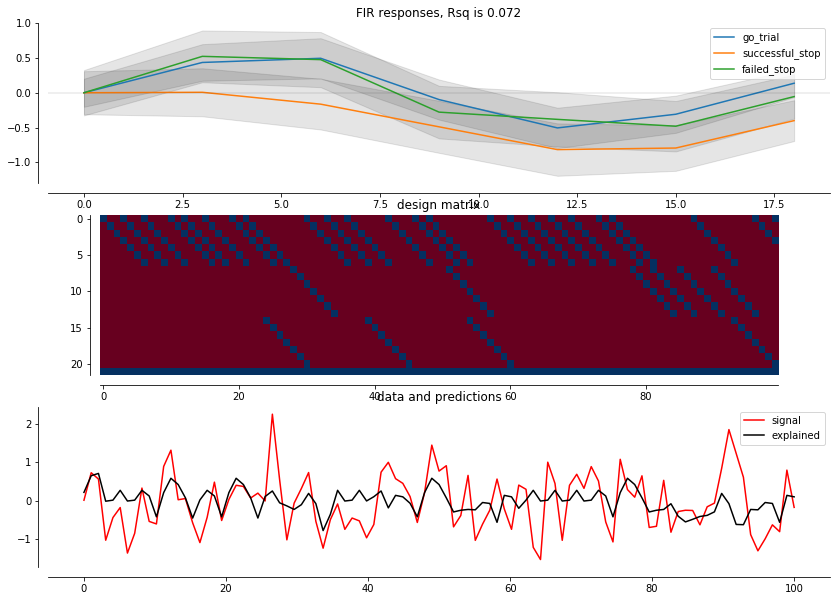

In [37]:
# denoised data

import matplotlib.pyplot as plt
import seaborn as sn
import fir
sample_rate = 1/3.
deconv_frequency=None
interval = 18
fd = fir.FIRDeconvolution(signal=np.hstack(data), 
                          events=events, 
                          event_names=('go_trial', 'successful_stop', 'failed_stop'), 
                          durations=durations,
                          sample_frequency=sample_rate, 
                          deconvolution_frequency=deconv_frequency, 
                          deconvolution_interval=[0,interval],)

fd.create_design_matrix()
fd.regress()
fd.betas_for_events()
fd.calculate_rsq()
fd.bootstrap_on_residuals(nr_repetitions=1000)

go_trial = np.array(fd.betas_per_event_type[0]).ravel()
successful_stop = np.array(fd.betas_per_event_type[1]).ravel()
failed_stop = np.array(fd.betas_per_event_type[2]).ravel()

# baseline the kernels:
go_trial = go_trial - go_trial[0].mean()
successful_stop = successful_stop - successful_stop[0].mean()
failed_stop = failed_stop - failed_stop[0].mean()

# plot:
plot_time = 100
figwidth, figheight = 14, 10

f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
#     for dec in fd.betas_per_event_type.squeeze():
#         plt.plot(fd.deconvolution_interval_timepoints, dec)

for i, beta in zip(range(fd.bootstrap_betas_per_event_type.shape[0]), [go_trial, successful_stop, failed_stop]):
    plt.plot(fd.deconvolution_interval_timepoints, beta)
    mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
    sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

    plt.fill_between(fd.deconvolution_interval_timepoints, 
                    beta - sb, 
                    beta + sb,
                    color = 'k',
                    alpha = 0.1)    

# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
plt.legend(fd.covariates.keys())
sn.despine(offset=10)

plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
plt.legend(['signal','explained'])
sn.despine(offset=10)
plt.show()

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inter

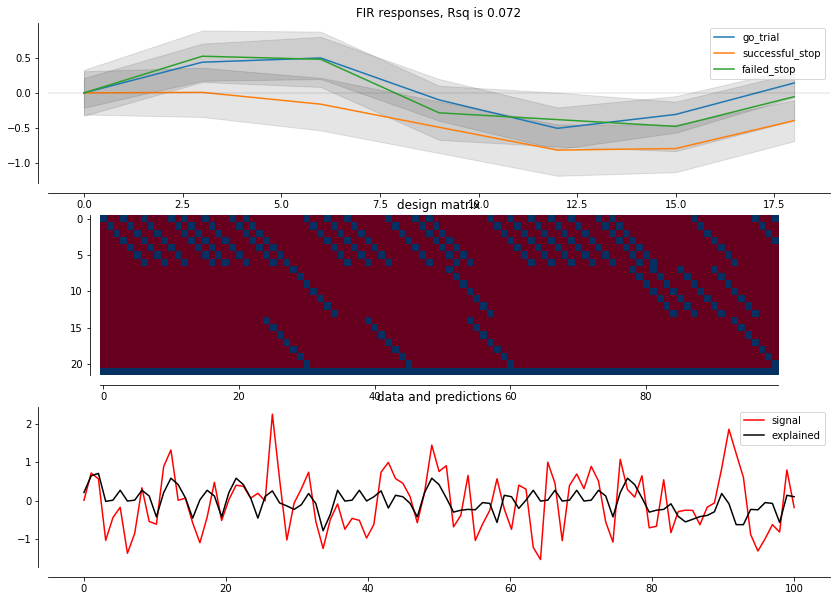

In [42]:
## Undenoised data

data2 = create_single_timeseries(['./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'],
                                  mask='masks/final_masks_mni09a_1p6mm/ACC_def-img.nii.gz')

import matplotlib.pyplot as plt
import seaborn as sn
import fir
sample_rate = 1/3.
deconv_frequency=None
interval = 18
fd = fir.FIRDeconvolution(signal=np.hstack(data2), 
                          events=events, 
                          event_names=('go_trial', 'successful_stop', 'failed_stop'), 
                          durations=durations,
                          sample_frequency=sample_rate, 
                          deconvolution_frequency=deconv_frequency, 
                          deconvolution_interval=[0,interval],)

fd.create_design_matrix()
fd.regress()
fd.betas_for_events()
fd.calculate_rsq()
fd.bootstrap_on_residuals(nr_repetitions=1000)

go_trial = np.array(fd.betas_per_event_type[0]).ravel()
successful_stop = np.array(fd.betas_per_event_type[1]).ravel()
failed_stop = np.array(fd.betas_per_event_type[2]).ravel()

# baseline the kernels:
go_trial = go_trial - go_trial[0].mean()
successful_stop = successful_stop - successful_stop[0].mean()
failed_stop = failed_stop - failed_stop[0].mean()

# plot:
plot_time = 100
figwidth, figheight = 14, 10

f = plt.figure(figsize = (figwidth, figheight))
s = f.add_subplot(311)
s.set_title('FIR responses, Rsq is %1.3f'%fd.rsq)
#     for dec in fd.betas_per_event_type.squeeze():
#         plt.plot(fd.deconvolution_interval_timepoints, dec)

for i, beta in zip(range(fd.bootstrap_betas_per_event_type.shape[0]), [go_trial, successful_stop, failed_stop]):
    plt.plot(fd.deconvolution_interval_timepoints, beta)
    mb = fd.bootstrap_betas_per_event_type[i].mean(axis = -1)
    sb = fd.bootstrap_betas_per_event_type[i].std(axis = -1)

    plt.fill_between(fd.deconvolution_interval_timepoints, 
                    beta - sb, 
                    beta + sb,
                    color = 'k',
                    alpha = 0.1)    

# fd.covariates, being a dictionary, cannot be assumed to maintain the event order. 
# working on a fix here....
plt.legend(fd.covariates.keys())
sn.despine(offset=10)

plt.axhline(0, lw=0.25, alpha=0.5, color = 'k')
s = f.add_subplot(312)
s.set_title('design matrix')
plt.imshow(fd.design_matrix[:,:plot_time], aspect = 0.075 * plot_time/fd.deconvolution_interval_size, cmap = 'RdBu', interpolation = 'nearest', rasterized = True)
sn.despine(offset=10)

s = f.add_subplot(313)
s.set_title('data and predictions')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.resampled_signal[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)].T, 'r')
plt.plot(np.linspace(0,plot_time, int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)), 
        fd.predict_from_design_matrix(fd.design_matrix[:,:int(plot_time * fd.deconvolution_frequency/fd.sample_frequency)]).T, 'k')
plt.legend(['signal','explained'])
sn.despine(offset=10)
plt.show()

(0, 100)

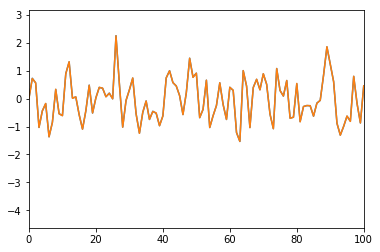

In [46]:
plt.plot(np.hstack(data))
plt.plot(np.hstack(data2))
plt.xlim(0, 100)

In [54]:
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/ACC_def-img.nii.gz').get_data()

com = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
com

[60, 97, 64]

In [49]:
data_me_undenoised = './data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
data_me_undenoised = nib.load(data_me_undenoised).get_data()
data_me_undenoised = data_me_undenoised[com[0], com[1], com[2], :]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [57]:
data_me_denoised = './lcat_denoising/sub-01_ses-me_task-stop_run-1_optcomb_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz'
data_me_denoised = nib.load(data_me_denoised).get_data()
data_me_denoised = data_me_denoised[com[0], com[1], com[2], :]

(0, 100)

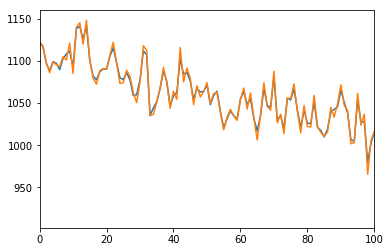

In [58]:
plt.plot(np.hstack(data_me_denoised))
plt.plot(np.hstack(data_me_undenoised))
plt.xlim(0, 100)

In [113]:
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STN_L_def-img.nii.gz').get_data()
com_stn_L = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STN_R_def-img.nii.gz').get_data()
com_stn_R = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]

mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STR_L_def-img.nii.gz').get_data()
com_str_L = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]
mask_data = nib.load('masks/final_masks_mni09a_1p6mm/STR_R_def-img.nii.gz').get_data()
com_str_R = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]


mask_data = nib.load('masks/final_masks_mni09a_1p6mm/ACC_def-img.nii.gz').get_data()
ACC = [int(np.round(x)) for x in sp.ndimage.measurements.center_of_mass(mask_data)]


In [70]:
### inspect individual echos
import glob
echos_undenoised = [nib.load(x).get_data() for x in glob.glob('./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-*_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz')]
echos_denoised = [nib.load(x).get_data() for x in glob.glob('./lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-*_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz')]

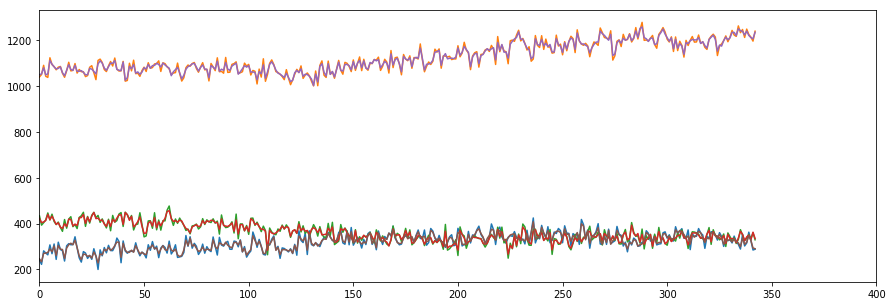

In [72]:
echos_undenoised_singlevox = [x[com_stn_L[0], com_stn_L[1], com_stn_L[2],:] for x in echos_undenoised]
echos_denoised_singlevox = [x[com_stn_L[0], com_stn_L[1], com_stn_L[2],:] for x in echos_denoised]

plt.plot(echos_undenoised_singlevox[0])
plt.plot(echos_undenoised_singlevox[1])
plt.plot(echos_undenoised_singlevox[2])

plt.plot(echos_denoised_singlevox[0])
plt.plot(echos_denoised_singlevox[1])
plt.plot(echos_denoised_singlevox[2])

plt.xlim(0, 400)
plt.gcf().set_size_inches(15, 5)

# STN_R

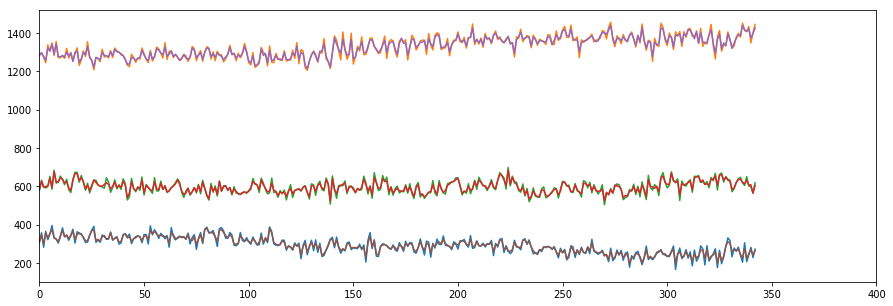

In [74]:
echos_undenoised_singlevox = [x[com_stn_R[0], com_stn_R[1], com_stn_R[2],:] for x in echos_undenoised]
echos_denoised_singlevox = [x[com_stn_R[0], com_stn_R[1], com_stn_R[2],:] for x in echos_denoised]

plt.plot(echos_undenoised_singlevox[0])
plt.plot(echos_undenoised_singlevox[1])
plt.plot(echos_undenoised_singlevox[2])

plt.plot(echos_denoised_singlevox[0])
plt.plot(echos_denoised_singlevox[1])
plt.plot(echos_denoised_singlevox[2])

plt.xlim(0, 400)
plt.gcf().set_size_inches(15, 5)

# STR L

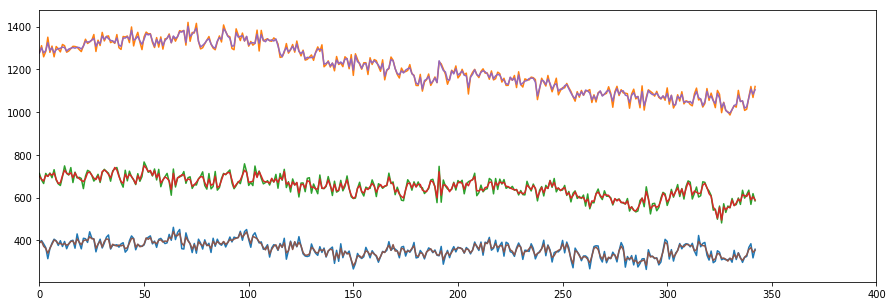

In [78]:
echos_undenoised_singlevox = [x[com_str_R[0], com_str_R[1], com_str_R[2],:] for x in echos_undenoised]
echos_denoised_singlevox = [x[com_str_R[0], com_str_R[1], com_str_R[2],:] for x in echos_denoised]

plt.plot(echos_undenoised_singlevox[0])
plt.plot(echos_undenoised_singlevox[1])
plt.plot(echos_undenoised_singlevox[2])

plt.plot(echos_denoised_singlevox[0])
plt.plot(echos_denoised_singlevox[1])
plt.plot(echos_denoised_singlevox[2])

plt.xlim(0, 400)
plt.gcf().set_size_inches(15, 5)

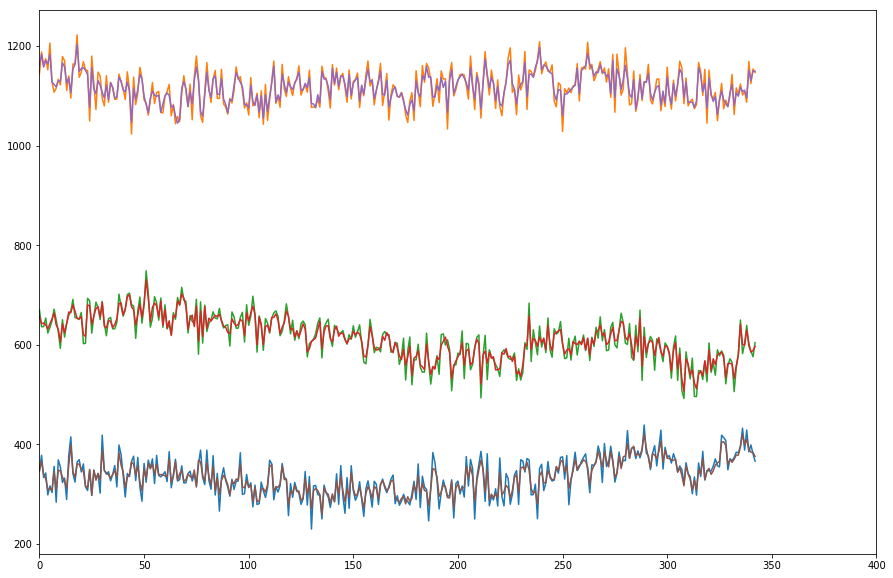

In [101]:
echos_undenoised_singlevox = [x[com_str_L[0], com_str_L[1], com_str_L[2],:] for x in echos_undenoised]
echos_denoised_singlevox = [x[com_str_L[0], com_str_L[1], com_str_L[2],:] for x in echos_denoised]

plt.plot(echos_undenoised_singlevox[0])
plt.plot(echos_undenoised_singlevox[1])
plt.plot(echos_undenoised_singlevox[2])

plt.plot(echos_denoised_singlevox[0])
plt.plot(echos_denoised_singlevox[1])
plt.plot(echos_denoised_singlevox[2])

plt.xlim(0, 400)
plt.gcf().set_size_inches(15, 10)

In [103]:
?sp.corrcoef

In [104]:
sp.corrcoef(echos_undenoised_singlevox[0], echos_undenoised_singlevox[1])

array([[1.        , 0.01621924],
       [0.01621924, 1.        ]])

In [105]:
sp.corrcoef(echos_denoised_singlevox[0], echos_denoised_singlevox[1])

array([[1.        , 0.01436108],
       [0.01436108, 1.        ]])

In [ ]:
e1_undenoised_filter = sp.signal.butter(echos_undenoised_singlevox[0], )

# STN_L mean (30%threshold?)

In [90]:
stn_l_meansignal = [create_single_timeseries([x], mask='./masks/final_masks_mni09a_1p6mm/STN_L_def-img.nii.gz', hp=None) for x in glob.glob('./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-*_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz')]

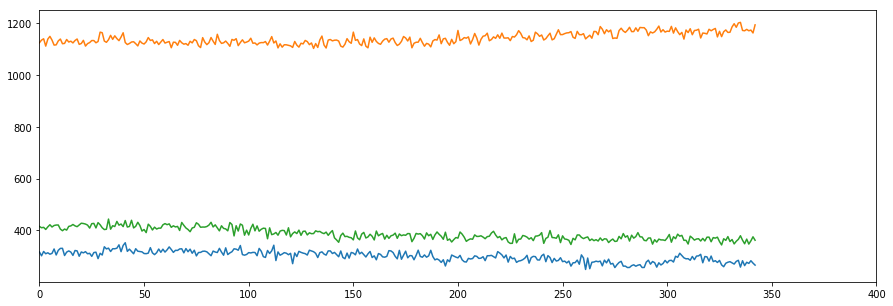

In [91]:
plt.plot(stn_l_meansignal[0][0])
plt.plot(stn_l_meansignal[1][0])
plt.plot(stn_l_meansignal[2][0])

plt.xlim(0, 400)
plt.gcf().set_size_inches(15, 5)

### Get rid of drifts *before* combining echos

In [94]:
from nilearn.input_data import NiftiMasker

echo1 = './data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
echo2 = './data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-2_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'
echo3 = './data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-3_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc.nii.gz'

masker = NiftiMasker()
X = masker.fit_transform(echo1)

/home/stevenm/miniconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


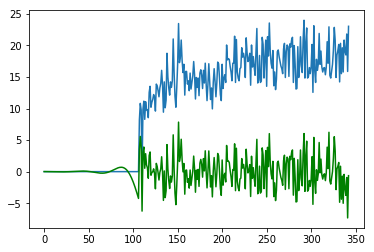

In [96]:
from nilearn.signal import butterworth
t_r = 3 
X_filtered = butterworth(signals=X, sampling_rate=1./t_r, high_pass=1/128., copy=True)
fmri_filtered = masker.inverse_transform(X_filtered)

# Timeseries of the 10th voxel
plt.plot(X[:,10])
plt.plot(X_filtered[:,10], 'g')

In [99]:
?butterworth

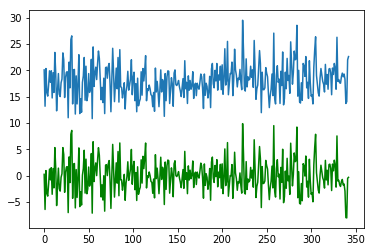

In [98]:
# Timeseries of the 10th voxel
plt.plot(X[:,200])
plt.plot(X_filtered[:,200], 'g')

In [109]:
### inspect individual echos
import glob
echos_raw = [nib.load(x).get_data() for x in glob.glob('./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-*_bold.nii')]
#echos_denoised = [nib.load(x).get_data() for x in glob.glob('./lcat_denoising/sub-01_ses-me_task-stop_run-1_echo-*_bold_space-mni_icbm152_t1_tal_nlin_asym_09a_brain_d4mm_preproc_lcat-den.nii.gz')]

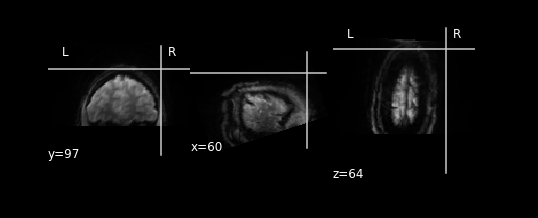

In [119]:
hdr = nib.load('./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_bold.nii')
def get_mean_img(hdr):
    if isinstance(hdr, str):
        hdr = nib.load(hdr)
    
    dat = hdr.get_data()
    dat = np.mean(dat, 3)
    img = nib.Nifti1Image(dat, hdr.affine)
    return(img)
plotting.plot_anat(get_mean_img(hdr), cut_coords=ACC)

In [122]:
np.round(hdr.affine, 2)

array([[-1.600e+00,  7.000e-02,  0.000e+00,  9.320e+01],
       [ 6.000e-02,  1.520e+00, -5.000e-01, -5.145e+01],
       [ 2.000e-02,  5.000e-01,  1.520e+00, -6.276e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00]])

(120, 120, 70)

In [139]:
?plt.imshow

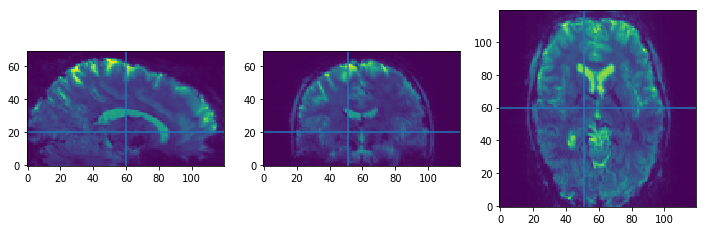

In [181]:
plot_point = [51, 60, 20]
f, axes = plt.subplots(1, 3)
#e1_mean = np.mean(echos_raw[0], 3)
axes[0].imshow(X=e1_mean[plot_point[0],:,:].T, origin='lower')
axes[0].axvline(plot_point[1])
axes[0].axhline(plot_point[2])

axes[1].imshow(X=e1_mean[:,plot_point[1],:].T, origin='lower')
axes[1].axvline(plot_point[0])
axes[1].axhline(plot_point[2])

axes[2].imshow(X=e1_mean[:,:,plot_point[2]].T, origin='lower')
axes[2].axvline(plot_point[0])
axes[2].axhline(plot_point[1])

f.set_size_inches(12,10)

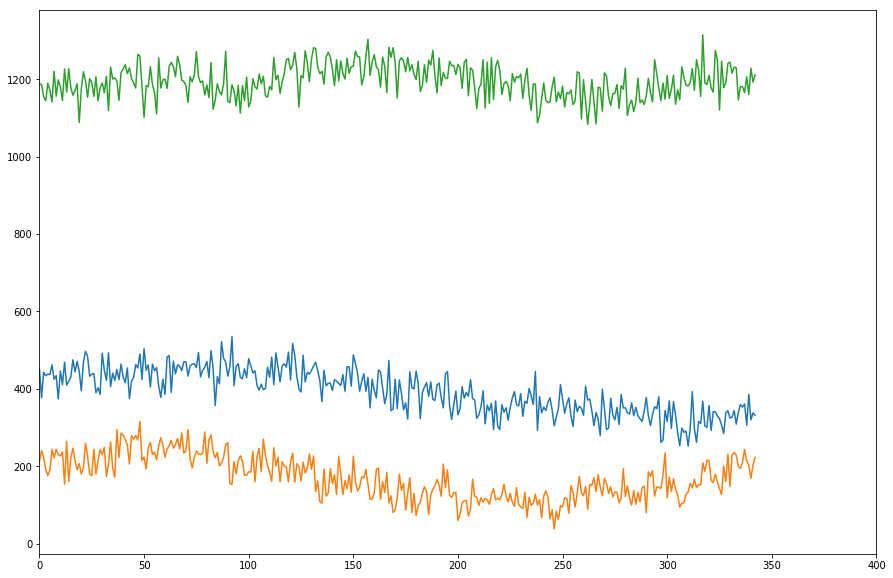

In [182]:
echos_raw_singlevox = [x[plot_point[0], plot_point[1], plot_point[2], :] for x in echos_raw]

plt.plot(echos_raw_singlevox[0])
plt.plot(echos_raw_singlevox[1])
plt.plot(echos_raw_singlevox[2])

plt.xlim(0, 400)
plt.gcf().set_size_inches(15, 10)

In [185]:
echo_fns = glob.glob('./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-*_bold.nii')
echo_fns.sort()
echo_fns

['./data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_bold.nii',
 './data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-2_bold.nii',
 './data/raw/bids/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-3_bold.nii']

In [ ]:
plot_point = [51, 60, 20]
f, axes = plt.subplots(1, 3)
#e1_mean = np.mean(echos_raw[0], 3)
axes[0].imshow(X=e1_mean[plot_point[0],:,:].T, origin='lower')
axes[0].axvline(plot_point[1])
axes[0].axhline(plot_point[2])

axes[1].imshow(X=e1_mean[:,plot_point[1],:].T, origin='lower')
axes[1].axvline(plot_point[0])
axes[1].axhline(plot_point[2])

axes[2].imshow(X=e1_mean[:,:,plot_point[2]].T, origin='lower')
axes[2].axvline(plot_point[0])
axes[2].axhline(plot_point[1])

f.set_size_inches(12,10)